In [1]:
from pathlib import Path
import random
from loguru import logger
import numpy as np
import torch
from torch.utils.data import Dataset
import sys
import matplotlib.pyplot as plt
import cv2
import math
try:
    import ganslate
except ImportError:
    sys.path.append('../')
    import ganslate
    

from ganslate.utils.io import make_recursive_dataset_of_files, load_json
from ganslate.utils import sitk_utils
from ganslate.data.utils import volume_invalid_check_and_replace
from ganslate.data.utils.normalization import min_max_normalize, min_max_denormalize
from ganslate.data.utils.register_truncate import truncate_CT_to_scope_of_CBCT
from ganslate.data.utils.fov_truncate import truncate_CBCT_based_on_fov
from ganslate.data.utils.body_mask import apply_body_mask_and_bound

from ganslate.data.utils.stochastic_focal_patching import StochasticFocalPatchSampler

from viz import show_mid_slices
import SimpleITK as sitk
import time

In [2]:
EXTENSIONS = ['.nrrd']

root_path = Path('/repos/Maastro/nki_cervix')

paths_CBCT = {}
paths_CT = {}

for patient in root_path.iterdir():
    paths_CBCT[patient.stem] = make_recursive_dataset_of_files(patient / "CBCT", EXTENSIONS)
    CT_nrrds = make_recursive_dataset_of_files(patient / "CT", EXTENSIONS)
    paths_CT[patient.stem] = [path for path in CT_nrrds if path.stem == "CT"]
    

In [3]:
patient_index = list(paths_CT)[2]

In [4]:
path_CBCT = paths_CBCT[patient_index][0]
path_CT = random.choice(paths_CT[patient_index])

In [5]:
# load nrrd as SimpleITK objects
CBCT = sitk_utils.load(path_CBCT)
CT = sitk_utils.load(path_CT)

In [6]:
# # Subtract 1024 from CBCT to map values from grayscale to HU approx
# ONLY FOR NKI DATA
CBCT = CBCT - 1024

In [7]:
CBCT = truncate_CBCT_based_on_fov(CBCT)

In [8]:
CT_truncated = truncate_CT_to_scope_of_CBCT(CT, CBCT)

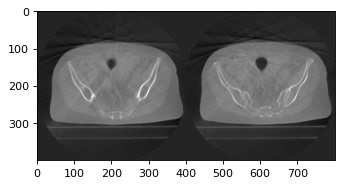

In [9]:
show_mid_slices(CBCT, show_axis=(False, False, True))

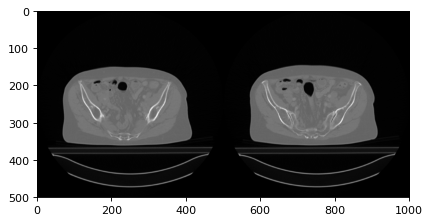

In [10]:
show_mid_slices(CT_truncated, show_axis=(False, False, True))

In [11]:
# Utility function to visualize the mask and bounds
def show_mask_bound(array, mask=None, bound=None):
    for n_slice in range(array.shape[0]):
        if mask is not None:
            fig, axs = plt.subplots(1, 2)
        else:
            fig, axs = plt.subplots(1, 1)
            
        img = array[n_slice]
        if bound is not None:
            cv2.rectangle(img, (bound[2][0], bound[1][0]), (bound[2][1], bound[1][1]), 3000, 2)
        
        if isinstance(axs, list):
            axs[0].imshow(img, cmap='gray')    
        else:
            axs.imshow(img, cmap='gray')    

        if mask is not None:
            axs[1].imshow(mask[n_slice], cmap='gray')
        plt.show()

In [12]:
CBCT_array = sitk.GetArrayFromImage(CBCT)

start_time = time.time()
masked_CBCT_array = apply_body_mask_and_bound(CBCT_array)
print(f"Time taken for masking: {time.time() - start_time}")

CBCT_array = apply_body_mask_and_bound(CBCT_array, apply_mask=False)

Number of connected components found: 601
Time taken for masking: 4.757202863693237
Number of connected components found: 601


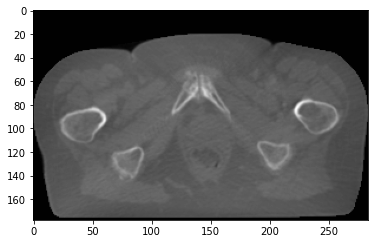

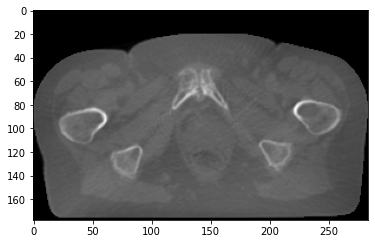

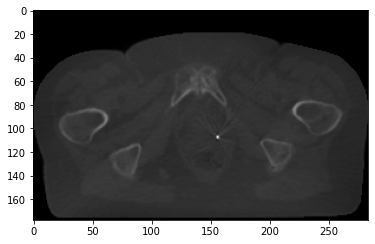

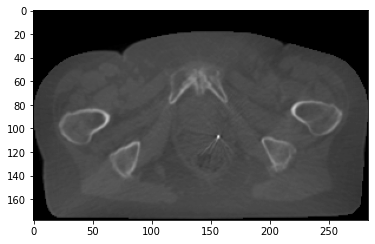

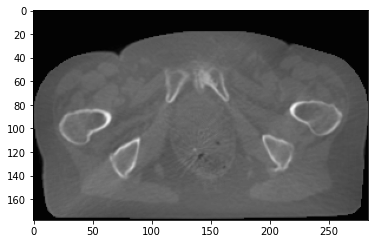

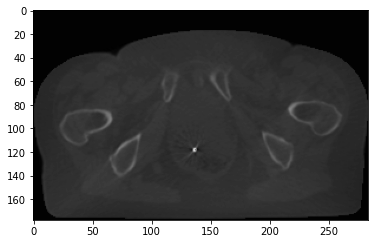

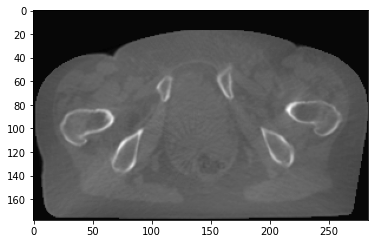

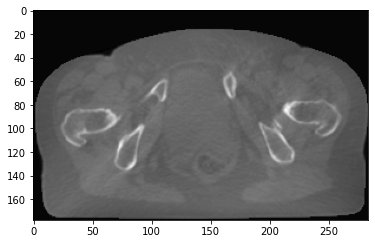

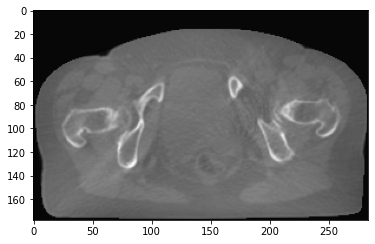

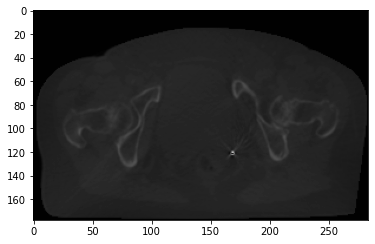

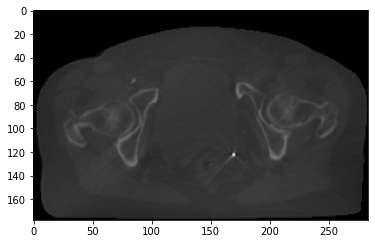

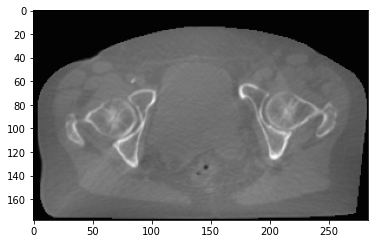

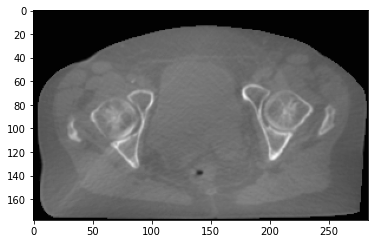

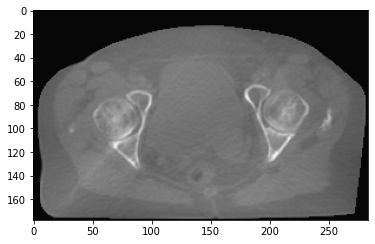

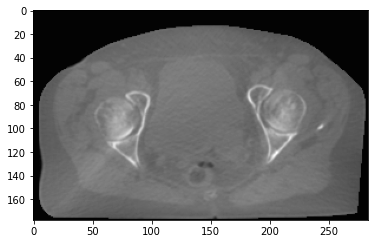

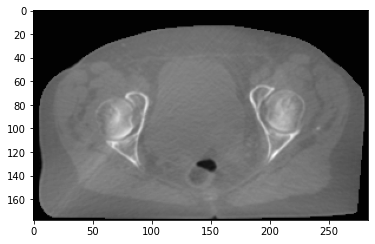

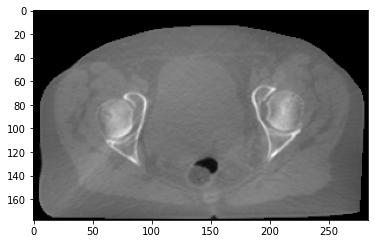

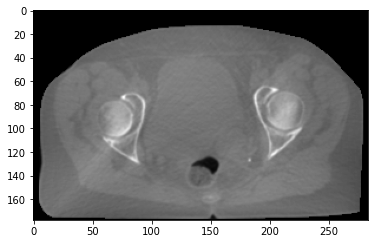

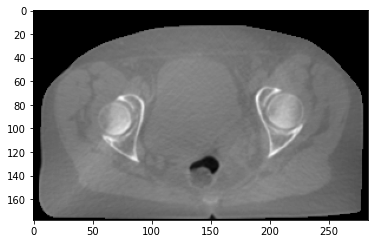

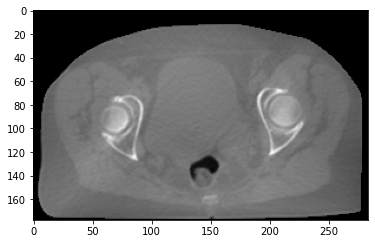

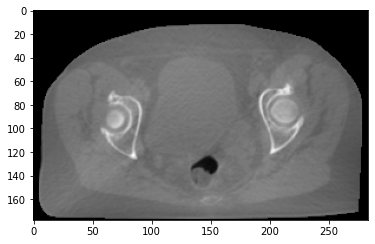

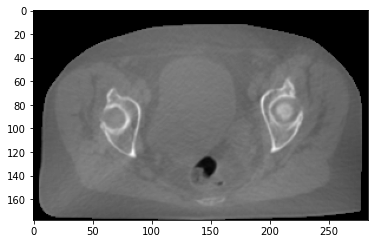

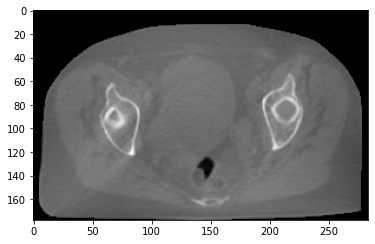

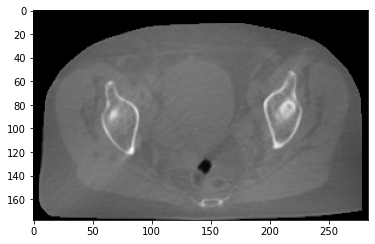

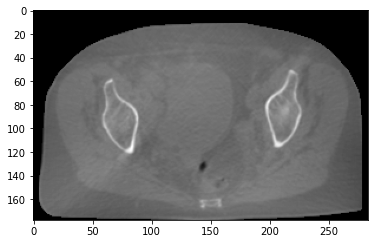

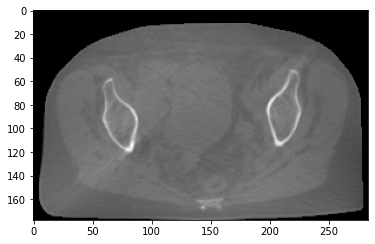

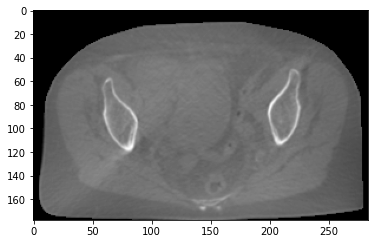

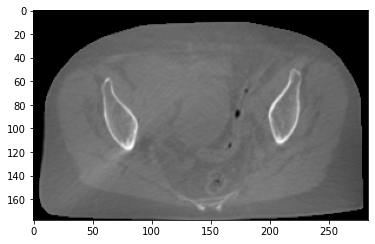

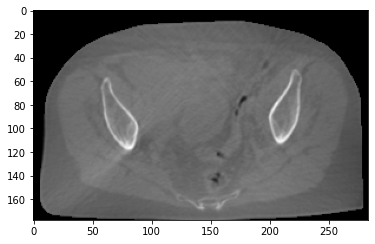

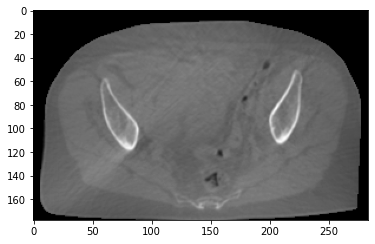

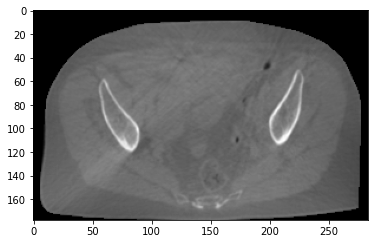

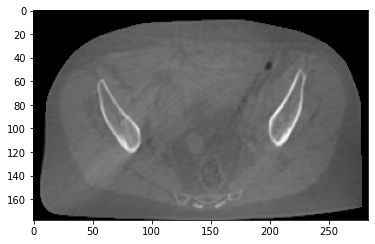

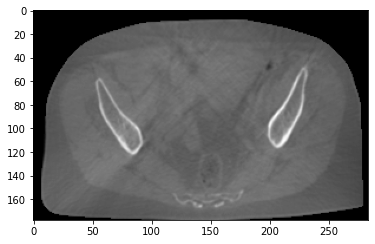

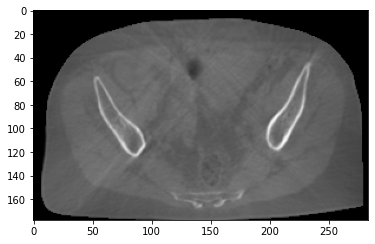

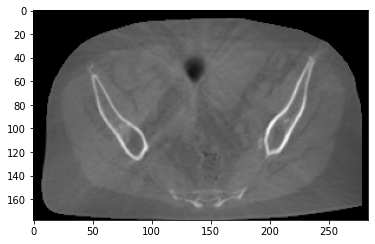

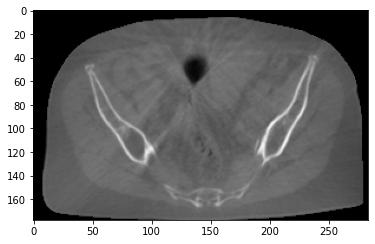

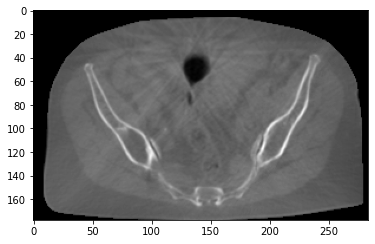

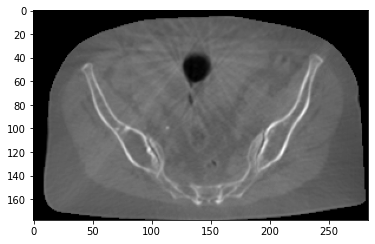

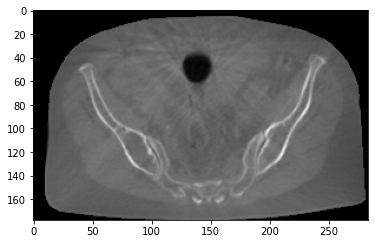

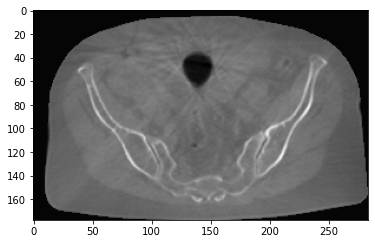

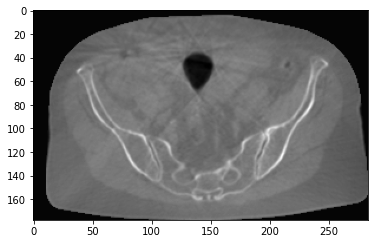

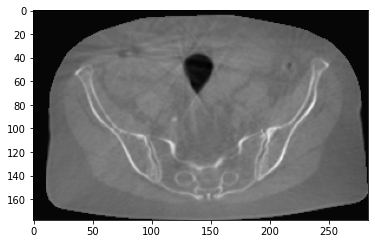

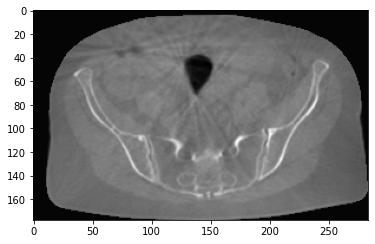

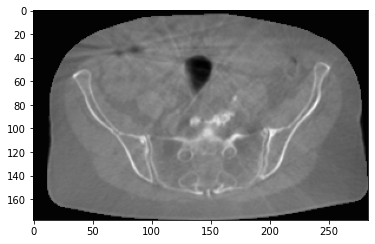

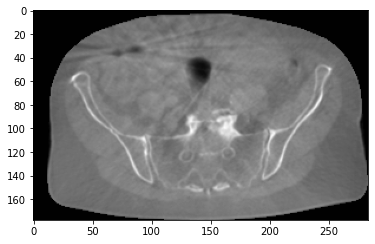

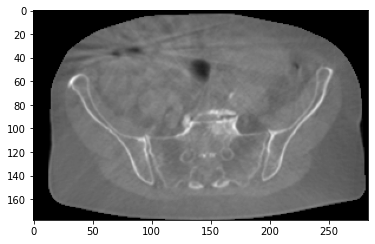

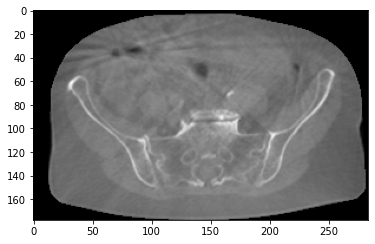

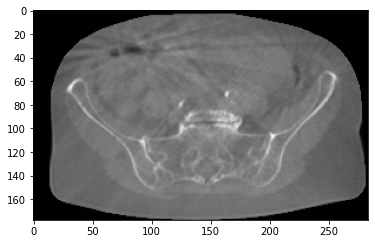

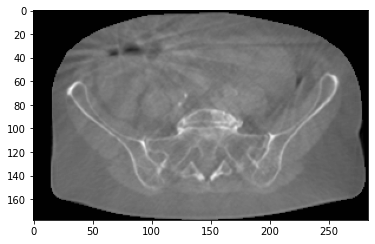

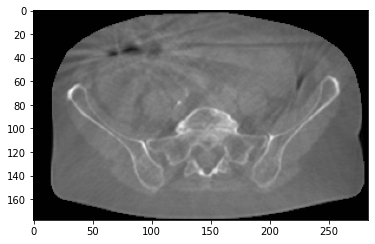

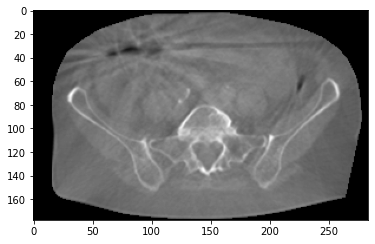

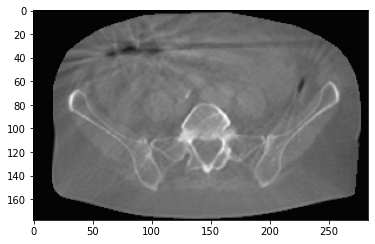

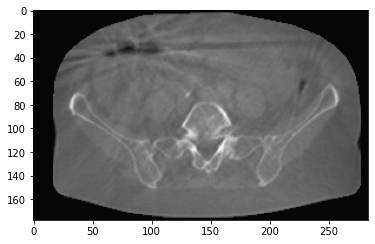

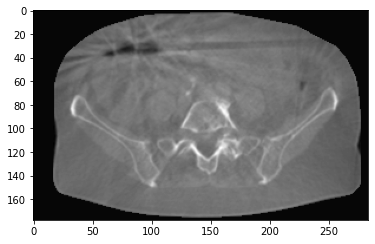

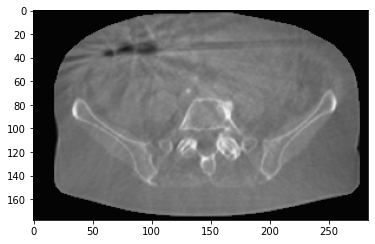

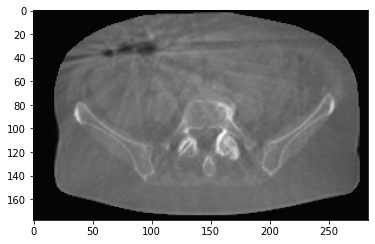

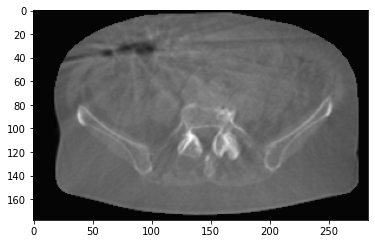

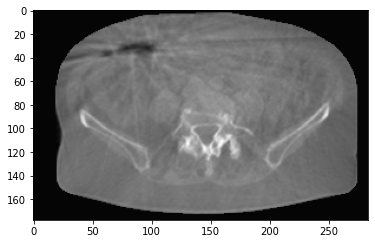

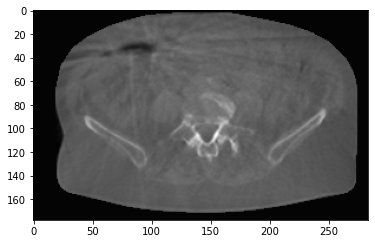

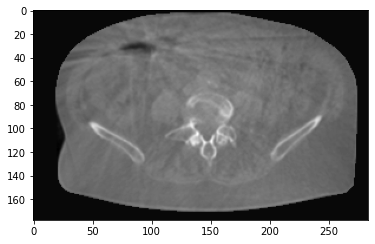

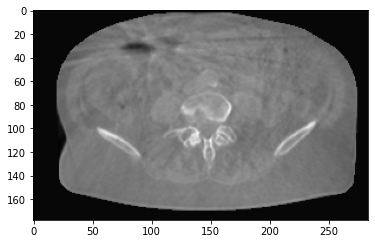

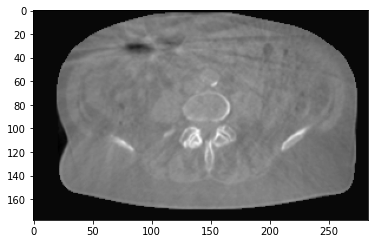

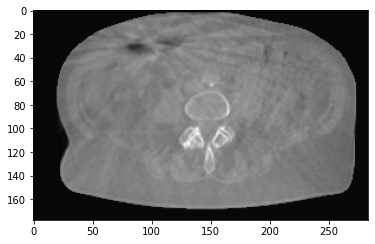

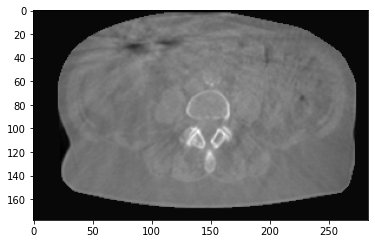

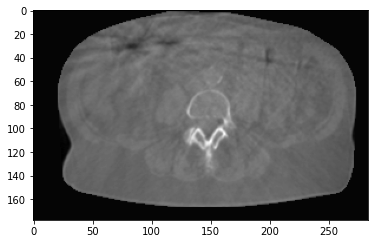

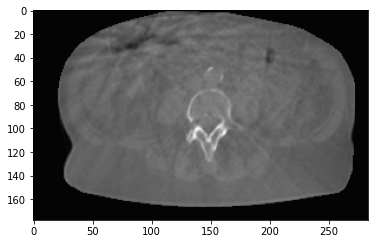

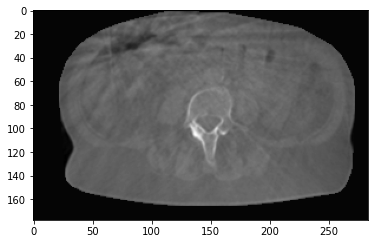

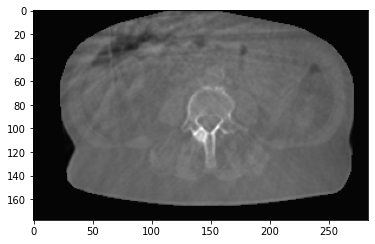

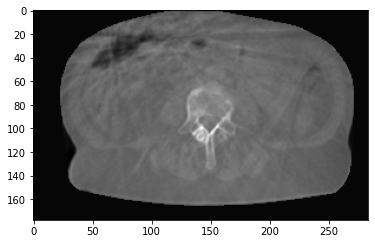

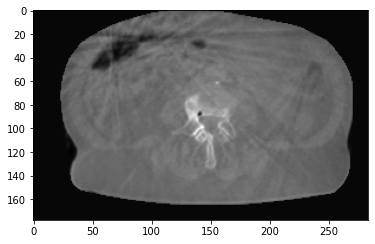

In [13]:
show_mask_bound(masked_CBCT_array)

In [14]:
CT_array = sitk.GetArrayFromImage(CT_truncated)
CT_array = apply_body_mask_and_bound(CT_array)
CT_array.shape

Number of connected components found: 49


(69, 175, 285)

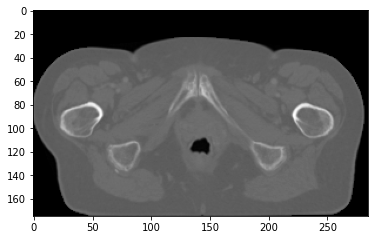

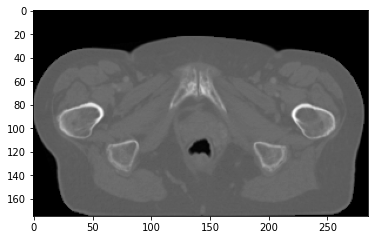

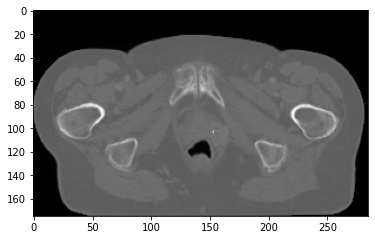

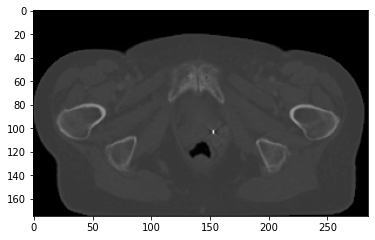

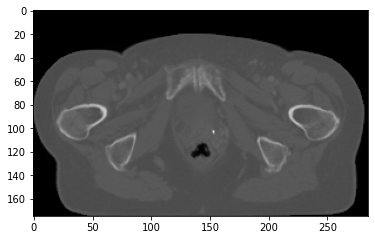

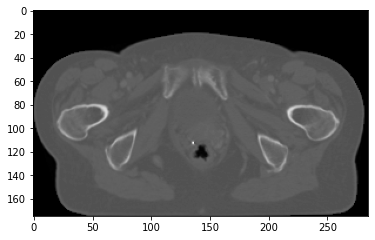

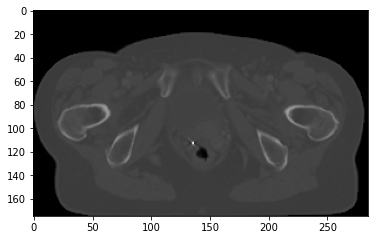

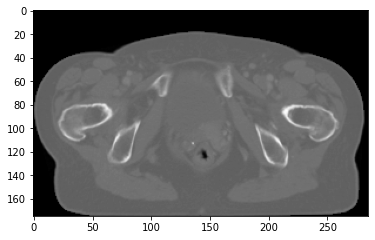

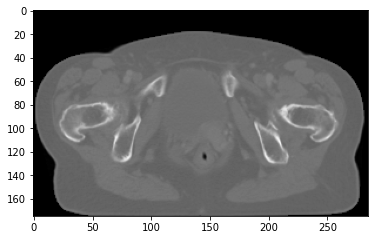

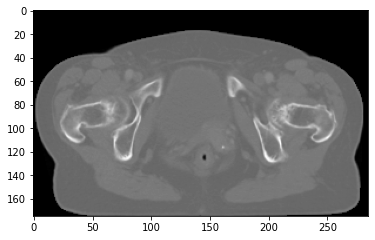

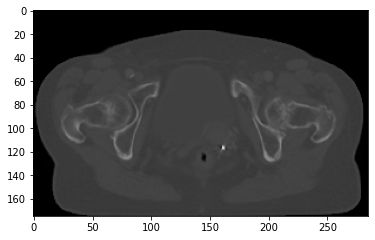

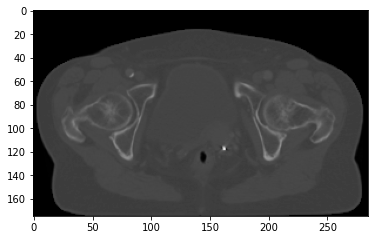

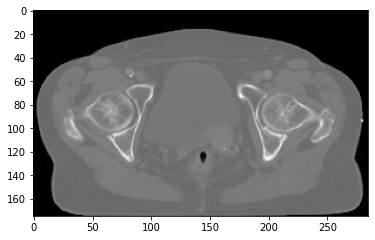

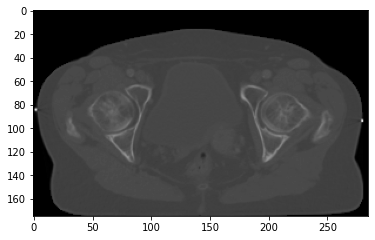

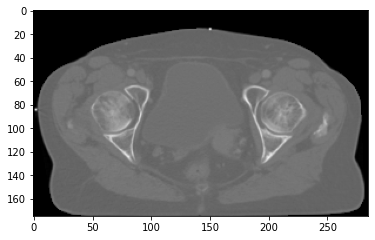

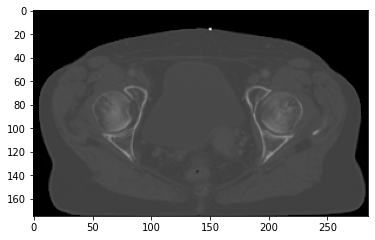

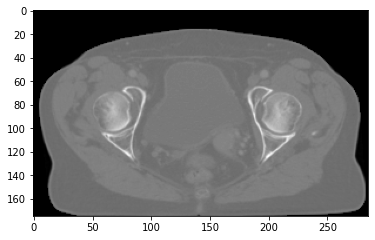

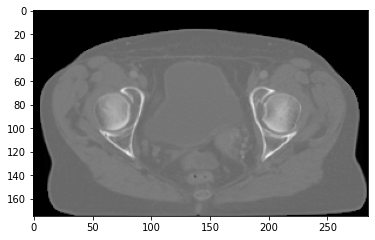

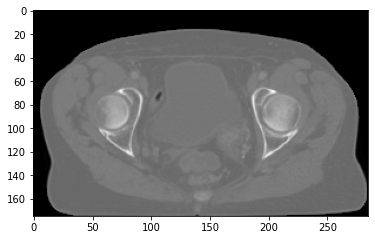

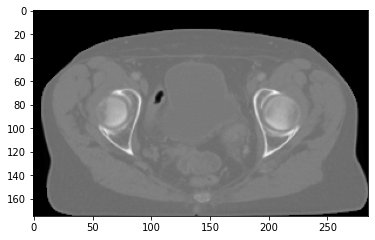

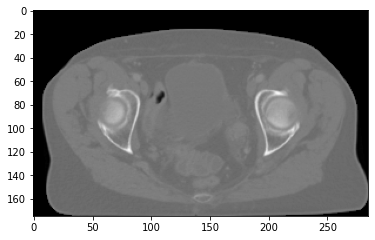

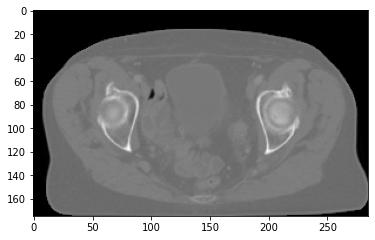

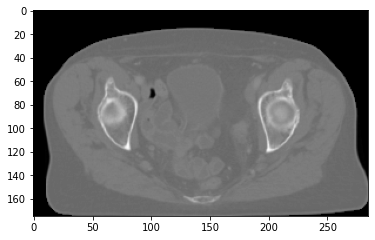

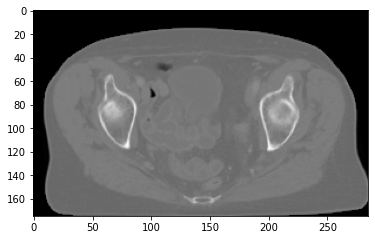

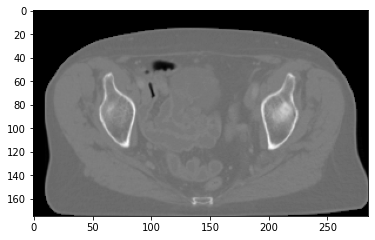

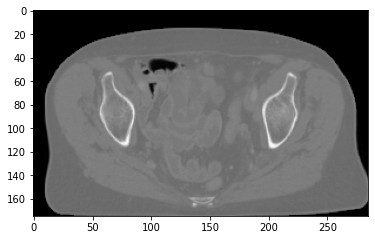

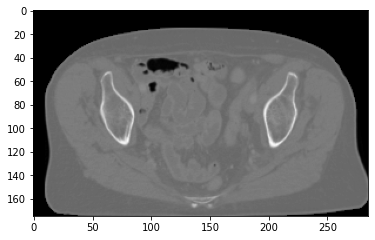

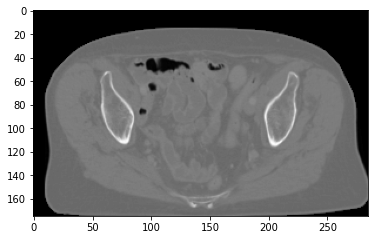

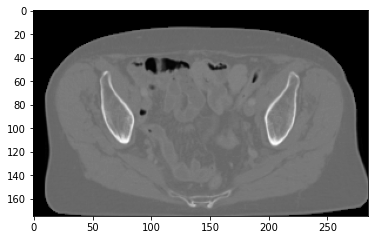

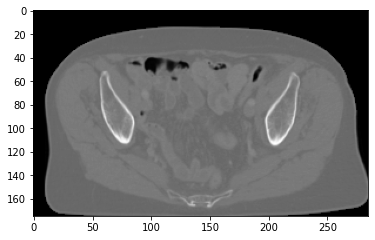

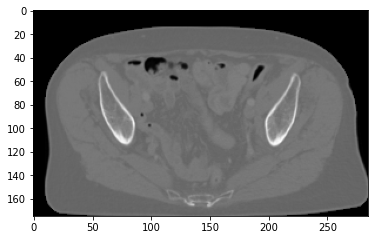

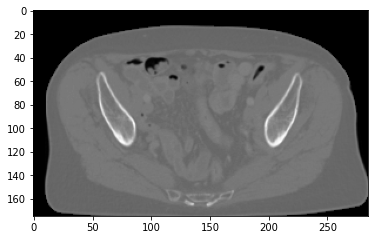

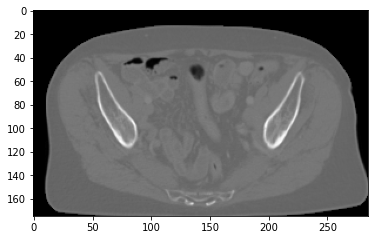

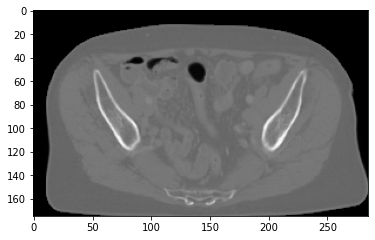

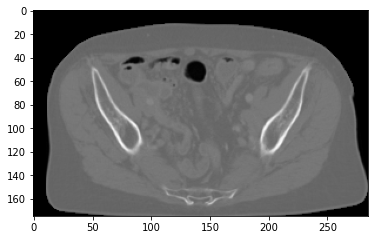

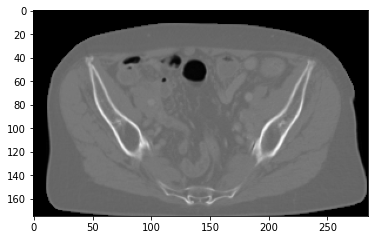

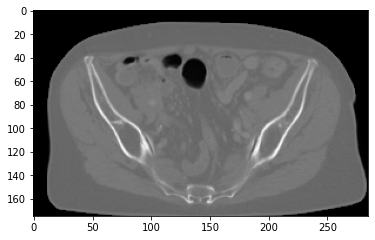

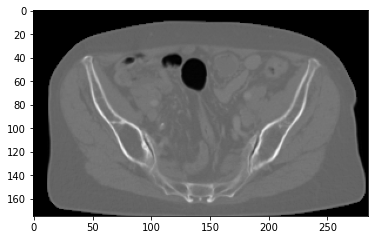

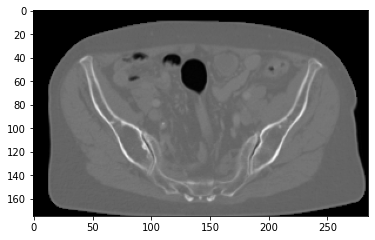

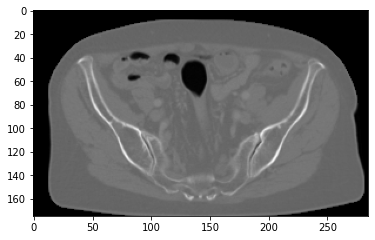

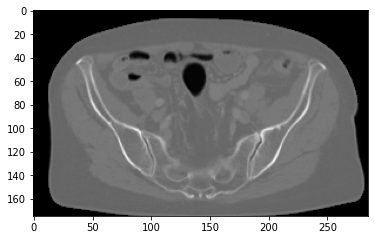

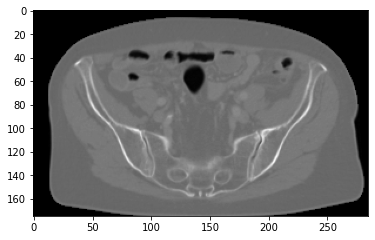

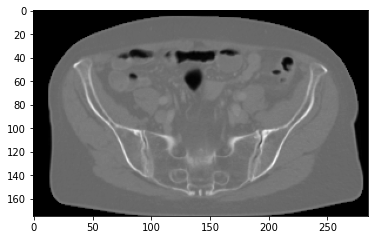

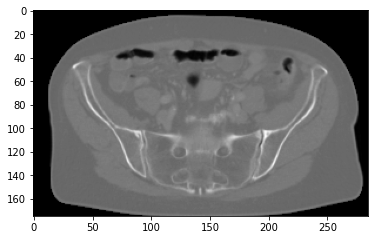

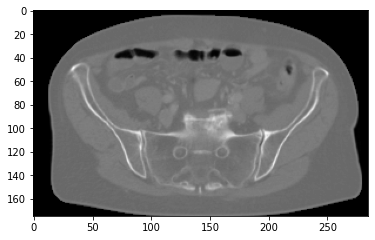

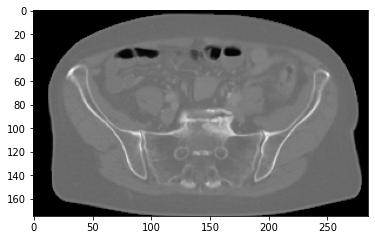

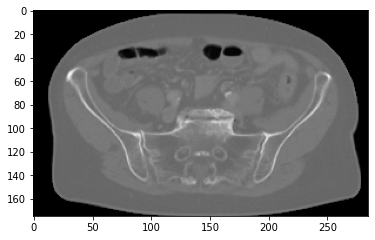

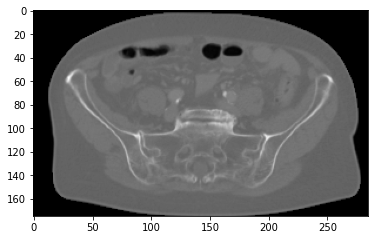

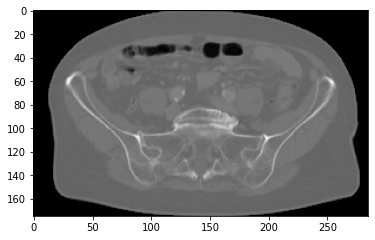

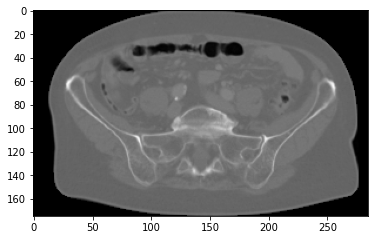

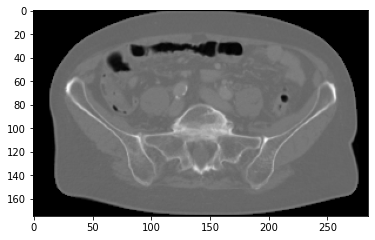

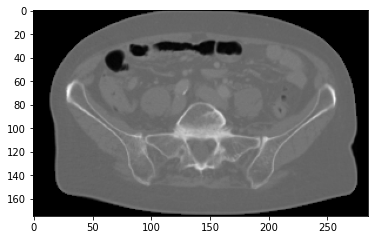

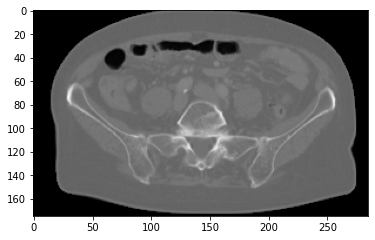

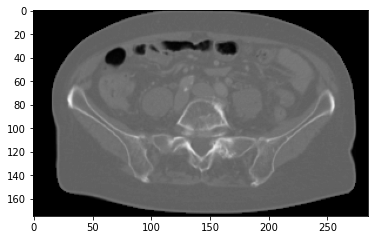

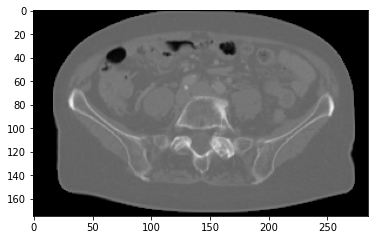

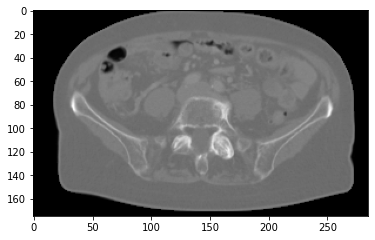

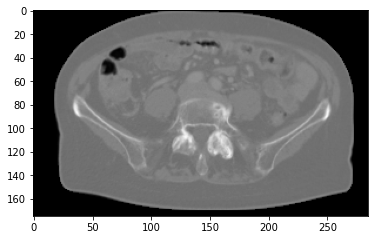

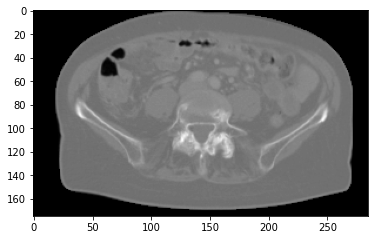

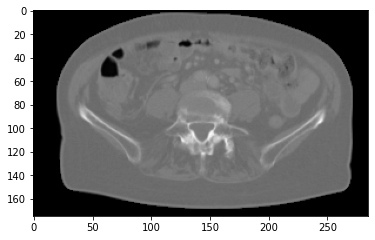

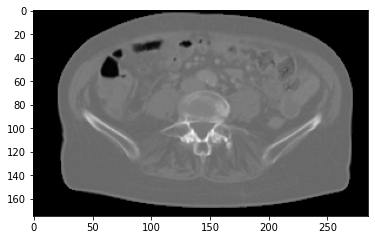

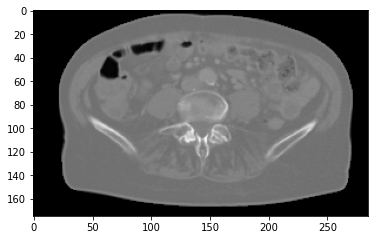

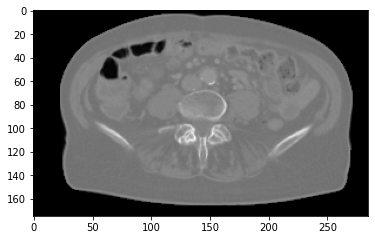

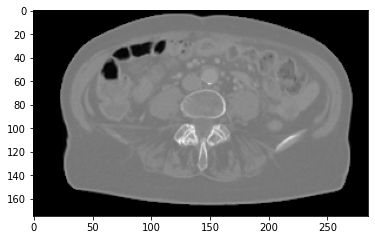

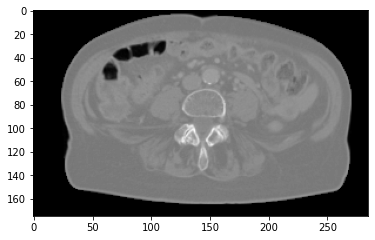

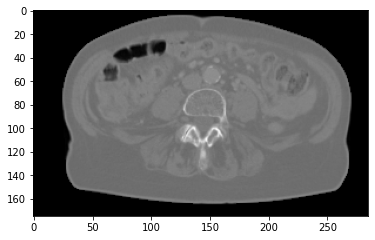

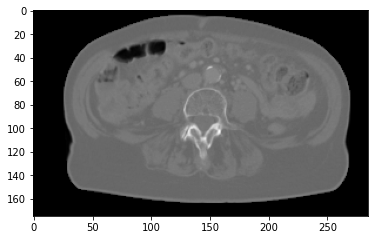

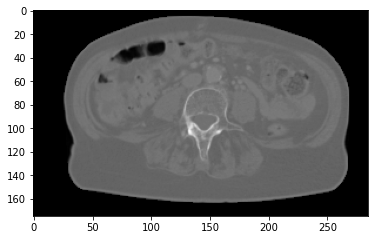

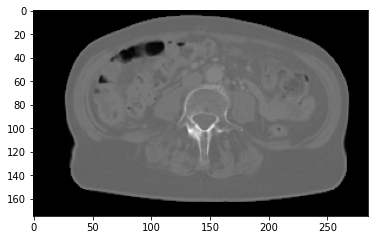

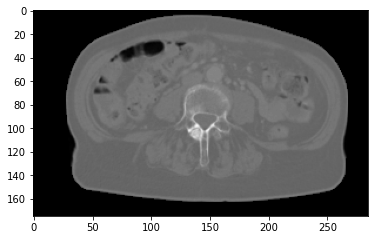

In [15]:
show_mask_bound(CT_array)

In [16]:
original = sitk.GetImageFromArray(CBCT_array)
original.SetSpacing(CBCT.GetSpacing())
original.SetOrigin(CBCT.GetOrigin())
original.SetDirection(CBCT.GetDirection())
sitk.WriteImage(original, 'original.nrrd', True)

In [17]:
masked = sitk.GetImageFromArray(masked_CBCT_array)
masked.SetSpacing(CBCT.GetSpacing())
masked.SetOrigin(CBCT.GetOrigin())
masked.SetDirection(CBCT.GetDirection())
sitk.WriteImage(masked, 'output.nrrd', True)